# Questions
 1. By using the FLIP algorithm, we get stuck in local optima. Should we maybe consider some explorability on the local search and therefore maybe lead to the global?
 2. Is there any recommended use of the flip algorithm? I considered here Best-Greedy-Flip and First-Better-Flip.
    The second seems to work better. Is it worth to include this in the written work?
   

In [1]:
import numpy as np
import networkx as nx
import networkx.drawing
import matplotlib.pyplot as plt
import time

%matplotlib

Using matplotlib backend: Qt5Agg


In [110]:
def PlotGraph(G, partition = None):
    G = nx.from_numpy_matrix(W)
    pos = nx.spring_layout(G)
    # Draw the graph according to node positions
    if partition is not None:
        colors= np.fromiter(partition.values(), dtype=int)+1
        nx.draw(G, pos, with_labels=True, node_color=colors)
    else:
        nx.draw(G, pos, with_labels=True)
    # Create edge labels
    labels = nx.get_edge_attributes(G, 'weight')

    # Draw edge labels according to node positions
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    plt.show()
    return

def InitializeGraph(n, min_weight, max_weight):
    W = np.random.uniform(low=min_weight, high=max_weight, size=(n,n))
    W = np.round((W + W.T)/2,2)
    np.fill_diagonal(W, 0)
    return W

def GetKRandomPartition(n, k):
    partition = {}
    for i in range(n):
        partition[i]=np.random.randint(low=0, high=k, size=1)[0]
    return partition

def CutCost(W, partition, n, k):
    z = 0
    identity = np.identity(k)
    for i in range(n):
        for j in range(i, n):
            z += (1-identity[partition[i], partition[j]])*W[i,j]
    return z
        
def CutGainAfterFlip(W, initial_partition, final_partition, n):
    # Vi: initial partition of the vertex v
    # Vj: final partition of the vertex v
    # z: current cut
    weights_to_add = 0
    weights_to_substract = 0
    
    diff_partition = {key: initial_partition[key] - final_partition.get(key, 0) for key in initial_partition}
    
    # v: vertex that flipped
    v = [key for key, val in diff_partition.items() if val!=0][0]
    Vi = initial_partition[v]
    Vj = final_partition[v]
    
    vertices_in_Vi = [key  for (key, value) in initial_partition.items() if value == Vi]
    vertices_in_Vj = [key  for (key, value) in initial_partition.items() if value == Vj]
    for vi in vertices_in_Vi:
        weights_to_add += W[v, vi]
    for vj in vertices_in_Vj:
        weights_to_substract += W[v, vj]
    z = weights_to_add - weights_to_substract
    return z
        
    
def GreedyBestFlip(W, partition, n, k, z):
    cut_costs = []
    partitions_flip = []
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            partitions_flip.append(new_partition)
            cut_costs.append(CutGainAfterFlip(W, partition, new_partition, n))
      
    # Convert the list to a numpy array
    cut_costs = np.asarray(cut_costs)
    if np.any(cut_costs[cut_costs>0]):
        # New best partition was found
        best_index = np.argmax(cut_costs)
        best_partition = partitions_flip[best_index]
        new_cut_cost = z + cut_costs[best_index]
        return best_partition, new_cut_cost
    else:
        # We are in a local optimum
        return partition, z
    
def FirstBetterFlip(W, partition, n, k, z):
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            new_z = CutGainAfterFlip(W, partition, new_partition, n)
            if new_z > 0:
                return new_partition, z + new_z
      
    return partition, z
    
def SolveMaxCut(W, n, k, z, initial_partition, method):
    tol = 1e-05
    maxIter = 1000
    it = 0
    
    zt1 = -1
    zt2 = CutCost(W, initial_partition, n, k)
    partition = initial_partition
    
    start = time.time()
    if method == "GreedyBestFlip":
        while(abs(zt1-zt2)>tol and it<maxIter):
            partition, new_z = GreedyBestFlip(W, partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
    elif method == "FirstBetterFlip":
        while(abs(zt1-zt2)>tol and it<maxIter):
            partition, new_z = FirstBetterFlip(W, partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
            
    end = time.time()
    elapsed_time = np.round(end - start, 4)
    return partition, new_z, elapsed_time

In [111]:
# Define main parameters
n = 6
k = 3
max_weight = 10
print(np.geomspace(2, 512, num=9, dtype=int))

[  2   4   7  16  32  64 127 256 512]


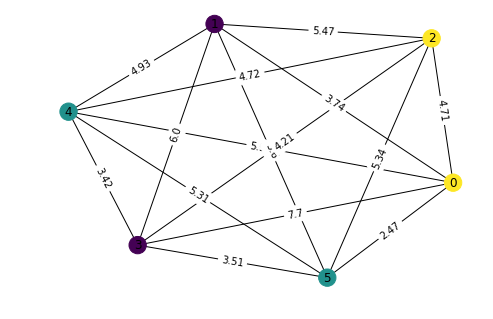

In [112]:
# Create graph and initial partition
W = InitializeGraph(n, min_weight=1, max_weight=10)

initial_partition = GetKRandomPartition(n, k)
initial_z = CutCost(W, initial_partition, n, k)

PlotGraph(W, initial_partition)

In [113]:
initial_partition = GetKRandomPartition(n, k)
initial_z = CutCost(W, initial_partition, n, k)

partition, z, elapsed_time = SolveMaxCut(W, n, k, initial_z, initial_partition, "GreedyBestFlip")
print(initial_z)
print(z)
print("Greedy Best Flip --> Elapsed time: " + str(elapsed_time) + " s.\n")

partition, z, elapsed_time = SolveMaxCut(W, n, k, initial_z, initial_partition, "FirstBetterFlip")
print(initial_z)
print(z)
print("First Better Flip --> Elapsed time: " + str(elapsed_time) + " s.")

40.61
61.459999999999994
Greedy Best Flip --> Elapsed time: 0.001 s.

40.61
57.05
First Better Flip --> Elapsed time: 0.0 s.


In [114]:
def RunGridMaxCut(min_nodes, max_nodes, step_nodes, min_k, max_k, min_weight, max_weight, iters_for_nk):

    nodes = np.geomspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    ks = range(min_k, max_k+1)

    times_mean = np.zeros((len(nodes), len(ks)))
    gaps_mean = np.zeros((len(nodes), len(ks)))
    i = 0
    j = 0

    for ni in nodes:
        for ki in ks:
            times = 0
            gaps = 0
            for it in range(1, iters_for_nk):
                # Create graph and initial partition
                W = InitializeGraph(ni, min_weight, max_weight)
                initial_partition = GetKRandomPartition(ni, ki)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, ki)
                # Get next local maximum
                partition, z, elapsed_time = SolveMaxCut(W, ni, ki, initial_z, initial_partition, "FirstBetterFlip")
                # Save results
                times += elapsed_time
                gaps += abs(z-initial_z)/initial_z

            times_mean[i,j] = np.mean(times)
            gaps_mean[i,j] = np.mean(gaps)
            j = j + 1
        j = 0
        i = i + 1
    return times_mean, gaps_mean


In [119]:
min_nodes = 8
max_nodes = 1024
num_nodes = 8
times_mean, gaps_mean = RunGridMaxCut(min_nodes, max_nodes, num_nodes, 2, 4, 1, 10, 10)

In [117]:
print(gaps_mean)

[[4.07529386 2.43354721 2.58051645]
 [1.16254454 1.44519985 0.99415776]
 [0.85787786 0.7823852  0.7278667 ]
 [0.52225712 0.52909134 0.56811994]
 [0.4383775  0.39383178 0.32854391]
 [0.27371507 0.24895104 0.23503308]
 [0.19293308 0.16933503 0.15178628]
 [0.13279443 0.11196867 0.09110041]]


In [118]:
print(times_mean)

[[6.000000e-03 5.000000e-03 1.000000e-02]
 [5.000000e-03 1.900000e-02 2.400000e-02]
 [3.600000e-02 9.400000e-02 1.298000e-01]
 [1.925000e-01 4.437000e-01 6.064000e-01]
 [9.295000e-01 2.188300e+00 3.011100e+00]
 [6.139700e+00 1.386800e+01 1.523430e+01]
 [3.892980e+01 6.637650e+01 8.533050e+01]
 [1.832857e+02 9.361750e+01 5.361600e+01]]


In [122]:
nodes = np.geomspace(min_nodes, max_nodes, num=num_nodes, dtype=int)
times_k2 = times_mean[:,0]

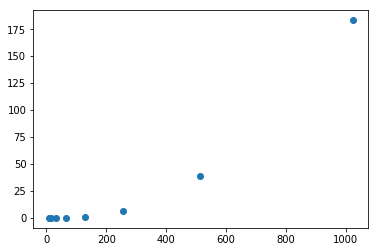

In [124]:
plt.scatter(nodes, times_k2)